# RF Spectrum Signal Classification

## Introduction
In this notebook, I train a computer vision model to classify RF signal types using waterfall spectrogram images. The goal is to build a baseline classifier using transfer learning (MobileNetV2) and then improve reliability by addressing class imbalance and adding lightweight parameter extraction for interpretability.

## Objectives
By the end of this notebook, I will:
- Download and inspect an RF spectrogram dataset from Kaggle
- Build a MobileNetV2 transfer-learning classifier for signal type recognition
- Evaluate performance on a validation split and test on random samples
- Handle class imbalance by filtering rare classes and retraining
- Extract simple frequency-band parameters (center frequency, bandwidth, SNR-like score) from spectrogram energy profiles

## Notebook Roadmap
1. Setup (Kaggle + dataset download)
2. Data exploration (folder structure, class distribution)
3. Baseline model (MobileNetV2 frozen backbone)
4. Improved training (filtered classes + early stopping)
5. Evaluation + qualitative testing
6. Parameter extraction (simple interpretability features)
7. Conclusions + future improvements



In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()


In [ ]:
import os, shutil
from pathlib import Path

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

if Path("kaggle.json").exists():
    shutil.move("kaggle.json", kaggle_dir / "kaggle.json")

os.chmod(kaggle_dir / "kaggle.json", 0o600)

os.listdir(kaggle_dir)


['kaggle.json']

Loading Dataset

In [ ]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

!kaggle datasets download -d halcy0nic/radio-frequecy-rf-signal-image-classification -p data


Dataset URL: https://www.kaggle.com/datasets/halcy0nic/radio-frequecy-rf-signal-image-classification
License(s): MIT
 99% 2.39G/2.42G [00:41<00:00, 40.4MB/s]
100% 2.42G/2.42G [00:41<00:00, 62.7MB/s]


In [ ]:
import zipfile

zip_path = data_dir / "radio-frequecy-rf-signal-image-classification.zip"
extract_dir = data_dir / "rf_signals"

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(dirs), "subdirs,", len(files), "files")
    if root.count(os.sep) - str(extract_dir).count(os.sep) > 1:
        break


data/rf_signals -> 1 subdirs, 0 files
data/rf_signals/datasets -> 2 subdirs, 0 files
data/rf_signals/datasets/waterfall -> 32 subdirs, 0 files


In [ ]:
import os

for root, dirs, files in os.walk("data/rf_signals/datasets/waterfall"):
    if len(files) > 0:
        print("Found files in:", root)
        print(files[:5])
        break


Found files in: data/rf_signals/datasets/waterfall/32QAM
['e86d8b8a1c5065c90bbdcd2661172ce3.png', '33588433b925d71bace8872a397d1e3f.png', '98a16acbd1da524f0e25ee78fd73ce6e.png', '6969a569db046789ccb0ce339f214dec.png', '9c662595f3c42d5c70dbcee89e9631c6.png']


In [ ]:
from pathlib import Path
import os

data_root = Path("data/rf_signals/datasets/waterfall")

print(data_root)
print(data_root.exists())
print(os.listdir(data_root)[:10])


data/rf_signals/datasets/waterfall
True
['32QAM', 'remote-keyless-entry', 'digital-audio-broadcasting', 'cellular', 'digital-speech-decoder', 'pocsag', 'bluetooth', 'sstv', 'hdmi', '16QAM']


In [ ]:
import tensorflow as tf

image_size = (224, 224)
batch_size = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

class_names, num_classes


Found 3993 files belonging to 32 classes.
Using 3195 files for training.
Found 3993 files belonging to 32 classes.
Using 798 files for validation.


(['16QAM',
  '2ASK',
  '32QAM',
  '4FSK',
  '8PSK',
  'RS41-Radiosonde',
  'Radioteletype',
  'ads-b',
  'airband',
  'ais',
  'am',
  'atsc',
  'automatic-picture-transmission',
  'bluetooth',
  'cellular',
  'digital-audio-broadcasting',
  'digital-speech-decoder',
  'drone-video',
  'fm',
  'hdmi',
  'lora',
  'morse',
  'on-off-keying',
  'packet',
  'pocsag',
  'remote-keyless-entry',
  'sstv',
  'uav-video',
  'unknown',
  'vor',
  'wifi',
  'z-wave'],
 32)

## Dataset Structure and Image Loading

The dataset is organized as:
- One folder per class label (e.g., `fm`, `lora`, `bluetooth`)
- Each folder contains spectrogram images in `.png` format

Next, I create TensorFlow datasets directly from the directory structure using an 80/20 train/validation split.


In [ ]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.prefetch(buffer_size=autotune)


In [ ]:
from tensorflow.keras import layers, models

image_size = (224, 224)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = layers.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,080 (9.25 MB)

 Trainable params: 168,096 (656.62 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Traininig

I train the classifier head for a small number of epochs using Adam optimization.  
I track both training accuracy and validation accuracy to check for early signs of overfitting.


In [ ]:
initial_lr = 1e-3

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
epochs_frozen = 7

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_frozen
)


Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9406 - loss: 0.2079 - val_accuracy: 0.9123 - val_loss: 0.3531
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step - accuracy: 0.9429 - loss: 0.2112 - val_accuracy: 0.9148 - val_loss: 0.3243
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.9394 - loss: 0.1923 - val_accuracy: 0.9160 - val_loss: 0.3374
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.9406 - loss: 0.1734 - val_accuracy: 0.9148 - val_loss: 0.3223
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.9559 - loss: 0.1386 - val_accuracy: 0.9248 - val_loss: 0.2904
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.9606 - loss: 0.1272 - val_accuracy: 0.9298 - val_loss: 0.2814
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9710 - loss: 0.1107 - val_accuracy: 0.9298 - val_loss: 0.2924


In [ ]:
model.save("rf_classifier.keras")


In [ ]:
from google.colab import files
files.download("rf_classifier.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Inference

In [ ]:
import numpy as np

def predict_single_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=image_size)
    arr = tf.keras.utils.img_to_array(img)
    arr = tf.expand_dims(arr, 0)
    arr = preprocess_input(arr)
    preds = model.predict(arr)
    idx = int(np.argmax(preds[0]))
    label = class_names[idx]
    confidence = float(preds[0][idx])
    return label, confidence

example_image = next(data_root.rglob("*.png"))
label, confidence = predict_single_image(str(example_image))
label, confidence, example_image


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


('cellular',
 0.09505883604288101,
 PosixPath('data/rf_signals/datasets/waterfall/am/597e841a25a262d49dce4e4d9b6f84c2.png'))

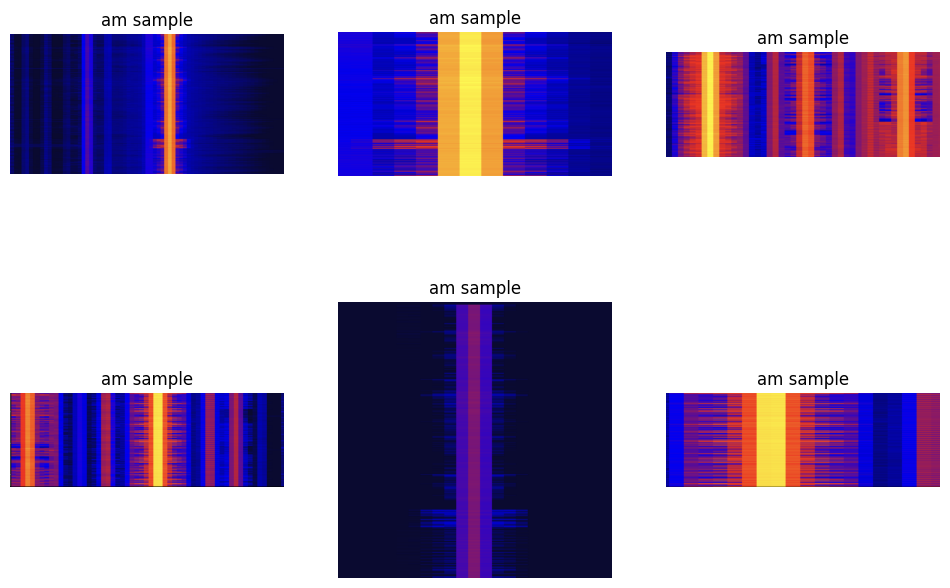

In [ ]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

am_folder = data_root / "am"
samples = list(am_folder.glob("*.png"))[:6]

plt.figure(figsize=(12, 8))
for i, path in enumerate(samples):
    img_bgr = cv2.imread(str(path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.title("am sample")
    plt.axis("off")


In [ ]:
import random

selected_classes = random.sample(class_names, 5)
selected_classes


['16QAM', '2ASK', 'digital-audio-broadcasting', 'fm', 'ais']

In [ ]:
from pathlib import Path

def test_on_class_samples(class_name, n_samples=5):
    folder = data_root / class_name
    files = list(folder.glob("*.png"))
    if not files:
        return []
    k = min(n_samples, len(files))
    samples = random.sample(files, k)
    results = []
    for path in samples:
        label, conf = predict_single_image(str(path))
        results.append((path.name, class_name, label, conf))
    return results


In [ ]:
from collections import Counter

counts = {}
for cls in class_names:
    folder = data_root / cls
    counts[cls] = len(list(folder.glob("*.png")))

sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]


[('fm', 735),
 ('lora', 593),
 ('cellular', 403),
 ('wifi', 293),
 ('packet', 290),
 ('RS41-Radiosonde', 276),
 ('bluetooth', 209),
 ('remote-keyless-entry', 128),
 ('ais', 111),
 ('z-wave', 93)]

In [ ]:
counts = {}
for cls in class_names:
    folder = data_root / cls
    counts[cls] = len(list(folder.glob("*.png")))

counts


{'16QAM': 8,
 '2ASK': 5,
 '32QAM': 8,
 '4FSK': 5,
 '8PSK': 8,
 'RS41-Radiosonde': 276,
 'Radioteletype': 27,
 'ads-b': 18,
 'airband': 66,
 'ais': 111,
 'am': 9,
 'atsc': 19,
 'automatic-picture-transmission': 46,
 'bluetooth': 209,
 'cellular': 403,
 'digital-audio-broadcasting': 65,
 'digital-speech-decoder': 50,
 'drone-video': 6,
 'fm': 735,
 'hdmi': 10,
 'lora': 593,
 'morse': 3,
 'on-off-keying': 0,
 'packet': 290,
 'pocsag': 0,
 'remote-keyless-entry': 128,
 'sstv': 92,
 'uav-video': 6,
 'unknown': 40,
 'vor': 84,
 'wifi': 293,
 'z-wave': 93}

In [ ]:
from pathlib import Path

data_root = Path("data/rf_signals/datasets/waterfall")

counts = {}
for cls in class_names:
    folder = data_root / cls
    counts[cls] = len(list(folder.glob("*.png")))

min_count = 50
kept_classes = sorted([cls for cls, c in counts.items() if c >= min_count])
dropped_classes = sorted([cls for cls, c in counts.items() if c < min_count])

kept_classes, dropped_classes


(['RS41-Radiosonde',
  'airband',
  'ais',
  'bluetooth',
  'cellular',
  'digital-audio-broadcasting',
  'digital-speech-decoder',
  'fm',
  'lora',
  'packet',
  'remote-keyless-entry',
  'sstv',
  'vor',
  'wifi',
  'z-wave'],
 ['16QAM',
  '2ASK',
  '32QAM',
  '4FSK',
  '8PSK',
  'Radioteletype',
  'ads-b',
  'am',
  'atsc',
  'automatic-picture-transmission',
  'drone-video',
  'hdmi',
  'morse',
  'on-off-keying',
  'pocsag',
  'uav-video',
  'unknown'])

In [ ]:
from pathlib import Path
import random

data_root = Path("data/rf_signals/datasets/waterfall")

all_images = []
for cls in kept_classes:
    folder = data_root / cls
    for f in folder.glob("*.png"):
        all_images.append((str(f), kept_classes.index(cls)))

len(all_images)


3488

In [ ]:
random.seed(42)
random.shuffle(all_images)

split = int(0.8 * len(all_images))
train_list = all_images[:split]
val_list = all_images[split:]

len(train_list), len(val_list)


(2790, 698)

In [ ]:
import tensorflow as tf

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, image_size)
    return img, label


In [ ]:
train_paths = [p for p, _ in train_list]
train_labels = [l for _, l in train_list]

val_paths = [p for p, _ in val_list]
val_labels = [l for _, l in val_list]

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
batch_size = 32

train_ds = (
    train_ds
    .shuffle(2000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
class_names = kept_classes
num_classes = len(kept_classes)

class_names, num_classes


(['RS41-Radiosonde',
  'airband',
  'ais',
  'bluetooth',
  'cellular',
  'digital-audio-broadcasting',
  'digital-speech-decoder',
  'fm',
  'lora',
  'packet',
  'remote-keyless-entry',
  'sstv',
  'vor',
  'wifi',
  'z-wave'],
 15)

In [ ]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = layers.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
initial_lr = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_stage1.keras",
    monitor="val_accuracy",
    save_best_only=True
)


In [ ]:
epochs_frozen = 50

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_frozen,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - accuracy: 0.1800 - loss: 2.7056 - val_accuracy: 0.5530 - val_loss: 1.6578
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.5579 - loss: 1.5447 - val_accuracy: 0.7235 - val_loss: 1.0730
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 269ms/step - accuracy: 0.7258 - loss: 0.9989 - val_accuracy: 0.7837 - val_loss: 0.8002
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 239ms/step - accuracy: 0.7907 - loss: 0.7911 - val_accuracy: 0.8438 - val_loss: 0.6330
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 266ms/step - accuracy: 0.8221 - loss: 0.6178 - val_accuracy: 0.8696 - val_loss: 0.5399
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 261ms/step - accuracy: 0.8661 - loss: 0.5209 - val_accuracy: 0.8840 - val_loss: 0.4763
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.8803 - loss: 0.4427 - val_accuracy: 0.8954 - val_loss: 0.4316
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.8995 - loss: 0.3951 - val_accu

In [ ]:
best_model = tf.keras.models.load_model("best_stage1.keras")

best_model.save("rf_classifier.keras")

from google.colab import files
files.download("rf_classifier.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

def predict_single_image_best(img_path):
    img = load_img(img_path, target_size=image_size)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    preds = best_model.predict(arr)[0]
    idx = int(np.argmax(preds))
    label = class_names[idx]
    confidence = float(preds[idx])
    return label, confidence, preds


In [ ]:
import random
from pathlib import Path

def test_on_class_samples_best(class_name, n_samples=5):
    folder = data_root / class_name
    files = list(folder.glob("*.png"))
    if not files:
        return []
    k = min(n_samples, len(files))
    samples = random.sample(files, k)
    results = []
    for path in samples:
        label, conf, _ = predict_single_image_best(str(path))
        results.append((path.name, class_name, label, conf))
    return results


In [ ]:
selected_classes = random.sample(class_names, min(5, len(class_names)))
selected_classes


['airband', 'bluetooth', 'digital-speech-decoder', 'z-wave', 'sstv']

In [ ]:
all_results = []

for cls in selected_classes:
    res = test_on_class_samples_best(cls, n_samples=5)
    if not res:
        continue
    correct = sum(1 for _, true, pred, _ in res if true == pred)
    print("Class:", cls)
    print(f"{correct}/{len(res)} correct")
    for fname, true, pred, conf in res:
        print(f"  {fname}  ->  pred: {pred:25s}  conf: {conf:.2f}")
    print()
    all_results.extend(res)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Class: airband
3/5 correct
  6607661ac507d92b24082cb91c49f8c5.png  ->  pred: lora                       conf: 0.40
  6f8eb9b687e7c01ee08170b1e5d118f4.png  ->  pred: remote-keyless-entry       conf: 0.36
  f70c568d5afb156433bbeaef715965e6.png  ->  pred: airband                    conf: 0.55
  62db70adf89842d9a008d39abf8b382f.png  ->  pred: airband                    conf: 0.28
  1092e7e394b559e49c1a192d70399ba7.png  ->  pred: airband                    conf: 0.46

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Class: bluetooth
3/5 correct
  da8405f83a94a81959ca55a4c6976337.png  ->  pred: bluetooth                  conf: 0.88
  1ee9fcf4b7cfad07a1f2050a391ad2ea.pn

## Parameter Extraction

Beyond classification, I extract simple interpretable features from each spectrogram image:
- **Normalized center frequency** (based on the column energy peak)
- **Normalized bandwidth** (active region width)
- **SNR-like score** (band energy minus background energy)


In [ ]:
!pip install -q opencv-python-headless

import cv2
import numpy as np
from pathlib import Path


## Feature Extraction Method

Each spectrogram is converted to grayscale and collapsed along the time axis to obtain a 1D energy profile across frequency.

From this energy profile:

1. A threshold is applied to detect the active signal band
2. The first and last active columns define the band boundaries
3. Center frequency and bandwidth are normalized by image width
4. Band energy is compared to background energy to compute contrast



In [ ]:
def load_spectrogram_gray(img_path):
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"Could not read image: {img_path}")
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype("float32") / 255.0
    return img_gray


In [ ]:
def extract_frequency_band_params(img_gray, energy_threshold_ratio=0.3):
    h, w = img_gray.shape
    col_energy = img_gray.mean(axis=0)
    max_energy = col_energy.max()
    if max_energy <= 0:
        return None
    threshold = max_energy * energy_threshold_ratio
    active = col_energy > threshold
    if not np.any(active):
        return None
    indices = np.where(active)[0]
    start = int(indices[0])
    end = int(indices[-1])
    center_x = (start + end) / 2.0
    band_width = max(1.0, float(end - start + 1))
    center_freq_norm = center_x / float(w)
    bandwidth_norm = band_width / float(w)
    band_energy = col_energy[start:end+1].mean()
    bg_mask = np.ones_like(col_energy, dtype=bool)
    bg_mask[start:end+1] = False
    if np.any(bg_mask):
        bg_energy = col_energy[bg_mask].mean()
    else:
        bg_energy = 0.0
    snr_like = float(band_energy - bg_energy)
    return {
        "center_freq_norm": float(center_freq_norm),
        "bandwidth_norm": float(bandwidth_norm),
        "snr_like": snr_like,
        "start_col": start,
        "end_col": end
    }


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

def analyze_signal(img_path):
    img = load_img(img_path, target_size=image_size)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    preds = best_model.predict(arr)[0]
    cls_idx = int(np.argmax(preds))
    cls_label = class_names[cls_idx]
    cls_conf = float(preds[cls_idx])
    img_gray = load_spectrogram_gray(img_path)
    band_params = extract_frequency_band_params(img_gray)
    result = {
        "predicted_class": cls_label,
        "confidence": cls_conf,
        "raw_probs": preds.tolist(),
        "band_params": band_params
    }
    return result


In [ ]:
example_path = str(next(data_root.rglob("*.png")))
analysis = analyze_signal(example_path)
analysis, example_path


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


({'predicted_class': 'ais',
  'confidence': 0.4018755257129669,
  'raw_probs': [0.0010771065717563033,
   0.00036118505522608757,
   0.4018755257129669,
   0.00092871836386621,
   0.04981788247823715,
   0.007389588747173548,
   0.0018504854524508119,
   0.34953323006629944,
   0.053752146661281586,
   3.4656468415050767e-06,
   0.00016066634270828217,
   0.0052472688257694244,
   0.07017730176448822,
   0.029792850837111473,
   0.028032656759023666],
  'band_params': {'center_freq_norm': 0.5831270627062707,
   'bandwidth_norm': 0.041254125412541254,
   'snr_like': 0.5097229480743408,
   'start_col': 1364,
   'end_col': 1463}},
 'data/rf_signals/datasets/waterfall/am/597e841a25a262d49dce4e4d9b6f84c2.png')

In [ ]:
import random

def analyze_random_from_class(cls, n=3):
    folder = data_root / cls
    files = list(folder.glob("*.png"))
    samples = random.sample(files, min(n, len(files)))
    for p in samples:
        res = analyze_signal(str(p))
        print("File:", p.name)
        print("True class:", cls)
        print("Predicted:", res["predicted_class"])
        print("Confidence:", f"{res['confidence']:.2f}")
        print("Band params:", res["band_params"])
        print()

test_classes = ["z-wave", "bluetooth", "sstv", "lora", "fm"]
for cls in test_classes:
    print("=== Testing class:", cls, "===")
    analyze_random_from_class(cls, n=3)
    print()


=== Testing class: z-wave ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
File: f12135b890c37cc89f27f3a8c4101dee.png
True class: z-wave
Predicted: z-wave
Confidence: 0.97
Band params: {'center_freq_norm': 0.49959612277867527, 'bandwidth_norm': 1.0, 'snr_like': 0.16710516810417175, 'start_col': 0, 'end_col': 1237}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
File: 34a8085a16e2bfce956a634f30c02c97.png
True class: z-wave
Predicted: z-wave
Confidence: 0.63
Band params: {'center_freq_norm': 0.49938800489596086, 'bandwidth_norm': 1.0, 'snr_like': 0.40594780445098877, 'start_col': 0, 'end_col': 816}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
File: ba3be348fbbf9c923d09607860a5cdc2.png
True class: z-wave
Predicted: z-wave
Confidence: 0.95
Band params: {'center_freq_norm': 0.5007892659826362, 'bandwidth_norm': 0.9834254143646409, 'snr_like': 0.14321714639663696, 'start_col': 12, 'end_col': 1257}


=== Testing class: bluetooth ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
File: 756601748369bd967246a83544bce2de.png
T

## Conclusion

This notebook demonstrates an end-to-end pipeline for RF signal classification using waterfall spectrogram images:

- Transfer learning enables strong baseline classification
- Filtering rare classes improves training stability
- Lightweight feature extraction adds interpretability

While the approach is image-based and simplified, it provides a practical framework for exploring RF signal recognition with modern computer vision tools.


In [ ]:
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

from google.colab import files
files.download("class_names.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

with open("kept_classes.json", "w") as f:
    json.dump(kept_classes, f)

from google.colab import files
files.download("kept_classes.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>